Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [156]:
import pandas as pd

npi_data = pd.read_csv('./data.csv')
npi_data

,score,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,Q34,Q35,Q36,Q37,Q38,Q39,Q40,elapse,gender,age
0,18,2,2,2,2,1,2,1,2,2,...,1,1,2,2,2,1,2,211,1,50
1,6,2,2,2,1,2,2,1,2,1,...,2,1,2,2,2,2,1,149,1,40
2,27,1,2,2,1,2,1,2,1,2,...,1,2,1,1,2,1,2,168,1,28
3,29,1,1,2,2,2,1,2,1,1,...,1,2,1,2,2,1,1,230,1,37
4,6,1,2,1,1,1,2,1,2,1,...,2,1,2,2,2,0,1,389,1,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11238,1,2,2,2,1,1,2,1,2,1,...,2,1,2,2,2,2,1,243,1,24
11239,10,2,2,1,1,1,2,1,1,1,...,2,1,2,1,2,2,1,197,1,39
11240,6,1,2,2,1,1,2,1,2,1,...,2,1,2,2,2,2,1,447,2,33
11241,12,2,2,1,1,1,1,1,1,1,...,1,2,2,2,2,2,1,167,1,24


In [157]:
npi_data['gender'].value_counts(normalize=True)                        

1    0.571467
2    0.423908
3    0.003558
0    0.001067
Name: gender, dtype: float64

In [158]:
npi_data.describe()

,score,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,Q34,Q35,Q36,Q37,Q38,Q39,Q40,elapse,gender,age
count,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,...,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,1.124300e+04,11243.000000,11243.000000
mean,13.299653,1.385751,1.784844,1.827804,1.174242,1.422307,1.628391,1.302944,1.412612,1.456106,...,1.667882,1.257582,1.807614,1.688695,1.845860,1.606955,1.414925,1.195542e+05,1.429956,34.014231
std,8.508833,0.489890,0.415898,0.382250,0.386075,0.498074,0.486375,0.463982,0.496285,0.505537,...,0.477931,0.449954,0.400239,0.471613,0.370342,0.495859,0.498831,1.262668e+07,0.504348,15.015611
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000e+00,0.000000,0.000000
25%,7.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.040000e+02,1.000000,23.000000
50%,12.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.570000e+02,1.000000,30.000000
75%,18.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.410000e+02,2.000000,43.000000
max,40.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.338845e+09,3.000000,509.000000


In [159]:
npi_data.shape

(11243, 44)

In [160]:
# look at gender value counts for whole dataset

npi_data['gender'].value_counts()

1    6425
2    4766
3      40
0      12
Name: gender, dtype: int64

In [161]:
# look at age value counts for whole dataset

npi_data['age'].value_counts()

22     459
20     452
21     451
19     423
23     414
      ... 
509      1
6        1
190      1
366      1
100      1
Name: age, Length: 83, dtype: int64

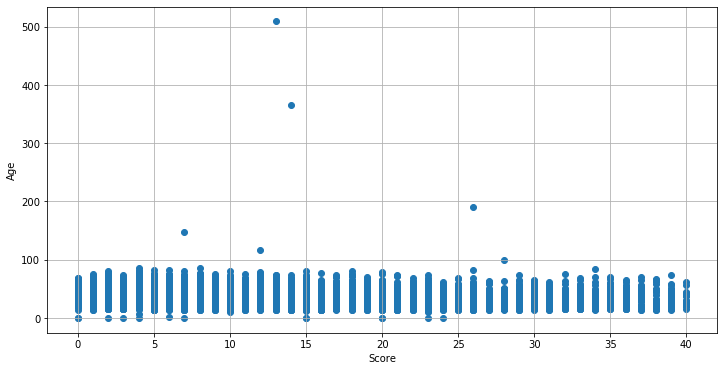

In [162]:
import matplotlib.pyplot as plt

# indentify outliers for age by using scatter plot 

fig, ax = plt.subplots(figsize=(12,6))
ax.grid()


ax.scatter(npi_data['score'], npi_data['age'])
ax.set_xlabel('Score')
ax.set_ylabel('Age')
plt.show()

In [163]:
# set age range for 15-100 years old for dataset 

index = npi_data[(npi_data['age'] >= 100)|(npi_data['age'] <= 15)].index
npi_data.drop(index, inplace=True)
npi_data['age'].describe()

count    11021.000000
mean        34.305780
std         13.657376
min         16.000000
25%         23.000000
50%         31.000000
75%         44.000000
max         86.000000
Name: age, dtype: float64

In [164]:
# clean gender column
# omitt useless gender from dataset '0'

index2 = npi_data[(npi_data['gender'] == 0)].index
npi_data.drop(index2, inplace=True)
npi_data['gender'].describe()

count    11009.000000
mean         1.429921
std          0.501287
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: gender, dtype: float64

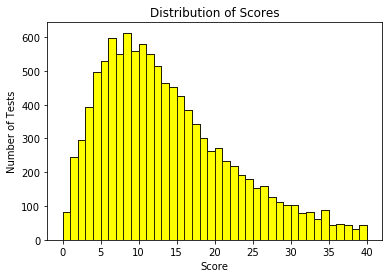

In [165]:
import seaborn as sns

# matplotlib histogram for distribution of scores
# historgram formatting

plt.hist(npi_data['score'], color = 'yellow', edgecolor = 'black',
         bins = 40)

sns.distplot(npi_data['score'], hist=True, kde=False, 
             bins=40, color = 'yellow',
             hist_kws={'edgecolor':'black'})

# add labels and title to histogram

plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Number of Tests')

plt.show()

### Train, Test, Validation Splits 70/15/15

In [166]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(npi_data, test_size=0.3,
                              stratify = npi_data['gender'], random_state = 42)

train.shape, test.shape

((7706, 44), (3303, 44))

In [167]:
test, val = train_test_split(test, test_size=0.5,
                              stratify = test['gender'], random_state = 42)
train.shape, test.shape, val.shape


((7706, 44), (1651, 44), (1652, 44))

### Feature Engineering 

In [168]:
def wrangle(X):
    
    X = X.copy()
    
    X['generation'] = pd.cut(X['age'], bins=[0, 25, 40, 55, 74, 100], 
                                       labels=['Gen Z', 'Millennials', 'Gen X', 
                                               'Baby Boomer Generation', 'The Silent Generation'])
        
        
    return X

In [169]:
test = wrangle(test)
test.drop('age', axis=1, inplace=True)
train = wrangle(train)
train.drop('age', axis=1, inplace=True)
val = wrangle(val)
val.drop('age', axis=1, inplace=True)

In [174]:
target = 'gender'
X_test = test.drop(columns=target)
y_test = test[target]
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]

### Decision Tree Classifier

In [275]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    DecisionTreeClassifier(random_state=42)
    
    
)
pipeline.fit(X_train, y_train)
print(f'Val score (acc): {pipeline.score(X_val, y_val)}')

Val score (acc): 0.538135593220339


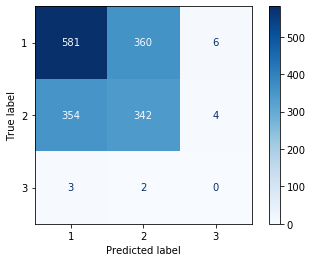

In [268]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_val, y_val, 
                      xticks_rotation='horizontal', 
                      values_format='.0f',
                      cmap='Blues');

In [269]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform


# set of parameters to test
params = {
    'decisiontreeclassifier__min_samples_split': [2, 10, 20],
    'decisiontreeclassifier__max_features': randint(1, 9), 
    'decisiontreeclassifier__max_depth': randint(1, 9)
                        }


search = RandomizedSearchCV(
    pipeline, 
    param_distributions=params, 
    n_iter=7, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  24 out of  35 | elapsed:    2.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:    2.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.3s finished


In [240]:
print('Best hyperparameters', search.best_params_)

Best hyperparameters {'decisiontreeclassifier__max_depth': 8, 'decisiontreeclassifier__max_features': 8, 'decisiontreeclassifier__min_samples_split': 2}


In [254]:
pipeline = make_pipeline(
    ce.OneHotEncoder(),
    DecisionTreeClassifier(max_features=8, max_depth=8, min_samples_split=2, random_state=42)
    
    
)
pipeline.fit(X_train, y_train)
print(f'Val score (acc): {pipeline.score(X_val, y_val)}')

Val score (acc): 0.5883777239709443


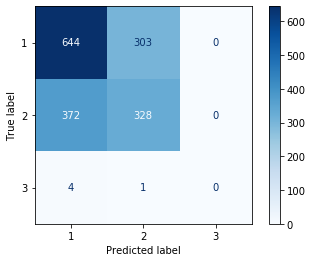

In [255]:
plot_confusion_matrix(pipeline, X_val, y_val, 
                      xticks_rotation='horizontal', 
                      values_format='.0f',
                      cmap='Blues');

In [256]:
y_pred = pipeline.predict(X_val)
roc_auc_score(y_pred, y_val)

0.5752419955323901

### Ridge ClassifierCV 

In [276]:
from sklearn.linear_model import RidgeClassifierCV
pipeline = make_pipeline(
    ce.OneHotEncoder(),
    RidgeClassifierCV()
)
pipeline.fit(X_train, y_train)
print(f'Val score (acc): {pipeline.score(X_val, y_val)}')

Val score (acc): 0.6398305084745762


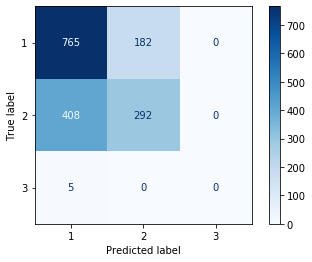

In [277]:
plot_confusion_matrix(pipeline, X_val, y_val, 
                      xticks_rotation='horizontal', 
                      values_format='.0f',
                      cmap='Blues');

In [278]:
y_pred = pipeline.predict(X_val)
roc_auc_score(y_pred, y_val)

0.6314123917388409

### Random Forest Classifier

In [285]:
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    RandomForestClassifier(random_state=42)
)
pipeline.fit(X_train, y_train)
print(f'Val score (acc): {pipeline.score(X_val, y_val)}')

Val score (acc): 0.6331719128329297


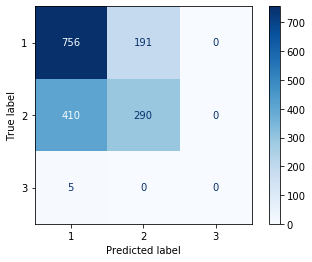

In [286]:
plot_confusion_matrix(pipeline, X_val, y_val, 
                      xticks_rotation='horizontal', 
                      values_format='.0f',
                      cmap='Blues');

In [287]:
y_pred = pipeline.predict(X_val)
roc_auc_score(y_pred, y_val)

0.622969155847038

### XGB Classifier 

In [293]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBClassifier(random_state=42)
)
pipeline.fit(X_train, y_train)
print(f'Val score (acc): {pipeline.score(X_val, y_val)}')

Val score (acc): 0.6368038740920097


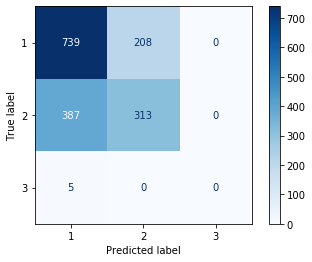

In [294]:
plot_confusion_matrix(pipeline, X_val, y_val, 
                      xticks_rotation='horizontal', 
                      values_format='.0f',
                      cmap='Blues');

In [295]:
y_pred = pipeline.predict(X_val)
roc_auc_score(y_pred, y_val)


0.625757953741275

### Decision Tree Classifier 

In [296]:
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    DecisionTreeClassifier(random_state=42)
)
pipeline.fit(X_train, y_train)
print(f'Val score (acc): {pipeline.score(X_val, y_val)}')

Val score (acc): 0.538135593220339


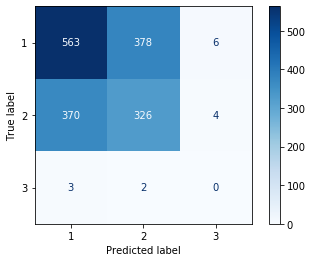

In [297]:
plot_confusion_matrix(pipeline, X_val, y_val, 
                      xticks_rotation='horizontal', 
                      values_format='.0f',
                      cmap='Blues');

### Extra Trees Classifier 

In [299]:
from sklearn.ensemble import ExtraTreesClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    ExtraTreesClassifier()
)
pipeline.fit(X_train, y_train)
print(f'Val score (acc): {pipeline.score(X_val, y_val)}')

Val score (acc): 0.6319612590799032


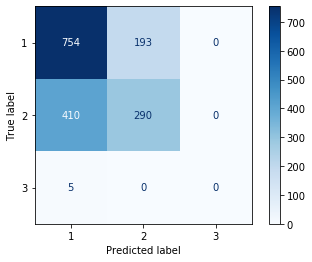

In [300]:
plot_confusion_matrix(pipeline, X_val, y_val, 
                      xticks_rotation='horizontal', 
                      values_format='.0f',
                      cmap='Blues');

In [301]:
y_pred = pipeline.predict(X_val)
roc_auc_score(y_pred, y_val)

0.6214208672273909